In [16]:
# ====== Cell 1: Imports & Reproducibility ======
import torch
import torch.nn.functional as F
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.nn import GCNConv
import networkx as nx
import numpy as np
import random
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import time

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    #qml.settings.random_seed = seed

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


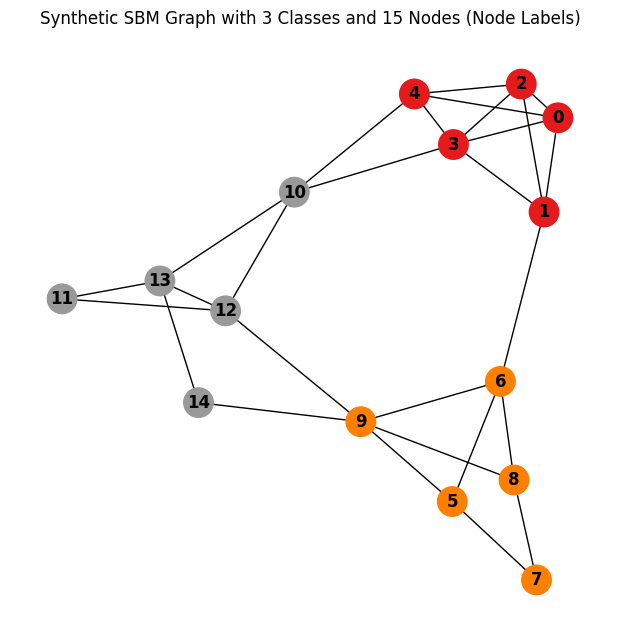

In [17]:
def generate_sbm_graph(n_nodes=15, n_classes=3, p_in=0.8, p_out=0.1):
    """
    Generate a SBM (Stochastic Block Model) synthetic graph with n_nodes and n_classes.
    p_in: probability of edge within same class
    p_out: probability of edge between classes
    Returns PyG Data object with x (node features), edge_index, and y (labels).
    """
    # Assign nodes evenly to classes
    sizes = [n_nodes // n_classes] * n_classes
    # Adjust last class size to cover all nodes if not evenly divisible
    sizes[-1] += n_nodes - sum(sizes)
    
    # Create probability matrix
    probs = np.full((n_classes, n_classes), p_out)
    np.fill_diagonal(probs, p_in)
    
    # Generate SBM graph with NetworkX
    G = nx.stochastic_block_model(sizes, probs, seed=42)
    
    # Node labels corresponding to block assignments
    labels = []
    for i, size in enumerate(sizes):
        labels.extend([i]*size)
    labels = torch.tensor(labels, dtype=torch.long)
    
    # Node features: one-hot encoding of class labels
    x = torch.nn.functional.one_hot(labels, num_classes=n_classes).float()
    
    # Convert NetworkX to PyG Data with edge_index
    data = from_networkx(G)
    data.x = x
    data.y = labels
    
    return data

# Generate train and test sets with the updated number of nodes
train_dataset = [generate_sbm_graph(n_nodes=15, n_classes=3, p_in=0.8, p_out=0.1) for _ in range(100)]
test_dataset = [generate_sbm_graph(n_nodes=15, n_classes=3, p_in=0.8, p_out=0.1) for _ in range(30)]

# Example visualization call remains the same:
visualize_graph(train_dataset[0], "Synthetic SBM Graph with 3 Classes and 15 Nodes (Node Labels)")


In [18]:
# ====== Cell 3: Classical 2-layer GCN Model ======

class ClassicalGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=3):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

input_dim = train_dataset[0].x.shape[1]
classical_model = ClassicalGCN(input_dim).to(device)


In [23]:
# ====== Cell 4: Simple Quantum Graph Neural Network (QGNN) ======

class SimpleQGNN(torch.nn.Module):
    def __init__(self, n_qubits=1, n_nodes=30, n_classes=3, device='lightning.gpu', classical_feat_dim=3):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.n_classes = n_classes
        self.total_qubits = n_qubits * n_nodes
        self.dev = qml.device(device, wires=self.total_qubits)

        self.node_rots = torch.nn.Parameter(torch.rand(n_qubits) * 2 * np.pi)
        self.edge_rots = torch.nn.Parameter(torch.rand(n_qubits, n_qubits) * 2 * np.pi)

        input_dim = n_qubits + 1 + classical_feat_dim
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, n_classes)
        )

    def circuit(self, edges, node_rots_values, edge_rots_values):
        for w in range(self.total_qubits):
            qml.Hadamard(wires=w)
        for node in range(self.n_nodes):
            for q in range(self.n_qubits):
                qml.RY(node_rots_values[q], wires=node * self.n_qubits + q)
        for e in range(edges.shape[1]):
            u, v = edges[0][e].item(), edges[1][e].item()
            for l in range(self.n_qubits):
                for r in range(self.n_qubits):
                    ql = u * self.n_qubits + l
                    qr = v * self.n_qubits + r
                    qml.ctrl(qml.RZ, control=ql)(edge_rots_values[l][r], wires=qr)

    def forward(self, graph):
        edges = graph.edge_index
        node_rots_values = self.node_rots
        edge_rots_values = self.edge_rots

        @qml.qnode(self.dev, interface='torch')
        def qnode():
            self.circuit(edges, node_rots_values, edge_rots_values)
            return qml.probs(wires=range(self.total_qubits))

        probs = qnode()
        per_node_counts = []
        for node in range(self.n_nodes):
            start = node * self.n_qubits
            end = (node + 1) * self.n_qubits
            counts_node = torch.zeros(self.n_qubits + 1, device=probs.device)
            for basis_idx, p in enumerate(probs):
                bitstring = format(basis_idx, f'0{self.total_qubits}b')
                ones_count = bitstring[-self.total_qubits:][start:end].count('1')
                counts_node[ones_count] += p
            per_node_counts.append(counts_node)

        x_quantum = torch.stack(per_node_counts)
        x_classical = graph.x.to(probs.device)
        x = torch.cat([x_quantum, x_classical], dim=1)
        logits = self.mlp(x)
        return logits

quantum_model = SimpleQGNN(
    n_qubits=1, n_nodes=15, n_classes=3, classical_feat_dim=train_dataset[0].x.shape[1]
).to(device)


DeviceError: Device lightning.gpu does not exist. Make sure the required plugin is installed.

In [20]:
# ====== Cell 5: Training & Evaluation Utilities ======

def train(model, dataset, num_epochs=50, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    losses, accuracies = [], []
    for epoch in range(1, num_epochs+1):
        total_loss, total_correct, total_nodes = 0, 0, 0
        start_time = time.time()
        for data in dataset:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (out.argmax(dim=1) == data.y).sum().item()
            total_nodes += data.y.size(0)
        epoch_loss = total_loss / len(dataset)
        epoch_acc = total_correct / total_nodes
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        if epoch % 10 == 0 or epoch == 1:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch:03d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}% | Time/epoch: {elapsed:.2f}s")
    return losses, accuracies

def evaluate(model, dataset):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in dataset:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu()
            y_pred.extend(preds.numpy())
            y_true.extend(data.y.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, digits=4)
    return acc, cm, cr, y_true, y_pred


In [ ]:
# ====== Cell 6: Train Classical GCN and Quantum QGNN, Evaluate & Time ======

# Train Classical GCN
print("Training Classical GCN:")
start = time.time()
classical_train_losses, classical_train_accs = train(classical_model, train_dataset, num_epochs=50, lr=0.01)
classical_train_time = time.time() - start
print(f"Classical GCN training time: {classical_train_time:.2f}s")

classical_test_acc, classical_cm, classical_cr, classical_ytrue, classical_ypred = evaluate(classical_model, test_dataset)
print(f"Classical GCN Test Accuracy: {classical_test_acc*100:.2f}%")

# Train Quantum QGNN
print("\nTraining Quantum QGNN:")
start = time.time()
quantum_train_losses, quantum_train_accs = train(quantum_model, train_dataset, num_epochs=50, lr=0.01)
quantum_train_time = time.time() - start
print(f"Quantum QGNN training time: {quantum_train_time:.2f}s")

quantum_test_acc, quantum_cm, quantum_cr, quantum_ytrue, quantum_ypred = evaluate(quantum_model, test_dataset)
print(f"Quantum QGNN Test Accuracy: {quantum_test_acc*100:.2f}%")


Training Classical GCN:
Epoch 001 | Loss: 0.0000 | Acc: 100.00% | Time/epoch: 0.16s
Epoch 010 | Loss: 0.0000 | Acc: 100.00% | Time/epoch: 0.14s
Epoch 020 | Loss: 0.0000 | Acc: 100.00% | Time/epoch: 0.14s
Epoch 030 | Loss: 0.0000 | Acc: 100.00% | Time/epoch: 0.14s
Epoch 040 | Loss: 0.0000 | Acc: 100.00% | Time/epoch: 0.14s
Epoch 050 | Loss: 0.0000 | Acc: 100.00% | Time/epoch: 0.13s
Classical GCN training time: 7.09s
Classical GCN Test Accuracy: 100.00%

Training Quantum QGNN:
Epoch 001 | Loss: 0.0000 | Acc: 100.00% | Time/epoch: 4968.36s


In [1]:
# ====== Cell 7: Visualization - Training Curves ======

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(classical_train_losses, label='Classical GCN')
plt.plot(quantum_train_losses, label='Quantum QGNN')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot([a*100 for a in classical_train_accs], label='Classical GCN')
plt.plot([a*100 for a in quantum_train_accs], label='Quantum QGNN')
plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


NameError: name 'plt' is not defined

In [ ]:
# ====== Cell 8: Visualization - Confusion Matrices ======

def plot_confusion(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion(classical_cm, "Classical GCN Confusion Matrix")
plot_confusion(quantum_cm, "Quantum QGNN Confusion Matrix")


In [ ]:
# ====== Cell 9: Visualization - Example Graph Prediction Comparison ======

sample_test_data = test_dataset[0].to(device)
classical_model.eval()
quantum_model.eval()

with torch.no_grad():
    classical_preds = classical_model(sample_test_data).argmax(dim=1).cpu().numpy()
    quantum_preds = quantum_model(sample_test_data).argmax(dim=1).cpu().numpy()
true_labels = sample_test_data.y.cpu().numpy()

G_sample = to_networkx(sample_test_data, to_undirected=True)
pos = nx.spring_layout(G_sample, seed=42)

def plot_graph_with_labels(G, labels, title):
    plt.figure(figsize=(6,6))
    cmap = plt.cm.Set1
    nx.draw(G, pos, labels={i: i for i in G.nodes()}, node_color=labels, cmap=cmap,
            node_size=500, font_color='white', font_weight='bold')
    plt.title(title)
    plt.show()

plot_graph_with_labels(G_sample, true_labels, "Ground Truth Node Labels")
plot_graph_with_labels(G_sample, classical_preds, "Classical GCN Predictions")
plot_graph_with_labels(G_sample, quantum_preds, "Quantum QGNN Predictions")


In [ ]:
# ====== Cell 10: Model Parameter Counts and Summary ======

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Classical GCN parameters: {count_parameters(classical_model)}")
print(f"Quantum QGNN parameters: {count_parameters(quantum_model)}")

print(f"Classical GCN layers: 2 (GCNConv layers)")
print(f"Quantum QGNN layers: 1 quantum layer + 2 MLP layers")

print(f"Classical GCN training time: {classical_train_time:.2f} seconds")
print(f"Quantum QGNN training time: {quantum_train_time:.2f} seconds")


In [ ]:
# ====== Cell 11: Detailed Classification Reports ======

print("Classical GCN Classification Report:\n", classical_cr)
print("\nQuantum QGNN Classification Report:\n", quantum_cr)
